## Setup

In [1]:
SAVE_FIGS = True

if not SAVE_FIGS:
  ![ -d cnn_txf_bias ] || git clone https://github.com/shikhartuli/cnn_txf_bias.git
  %cd cnn_txf_bias
else:
  !pip install SciencePlots
  from google.colab import drive
  drive.mount('/gdrive')
  root = '/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias'
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).

Changed CWD to "/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias"


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import jensenshannon
import scipy.stats
import itertools
import os

plt.style.reload_library()
js_dist_class_exp = {}
js_dist_inter_exp = {}
js_vs_cohen_exp = {}

PLOT_IMAGENET_ACC = True

acc_im = {}
if PLOT_IMAGENET_ACC:
  acc_im['ViT-B/32'] = eval(pd.read_csv(f'./vision_transformer/results/fine-tune/imagenet2012/vit_fine-tune.csv')['ImageNet Accuracy'][0][:-1])/100
  acc_im['ViT-B/32(ft.)'] = eval(pd.read_csv(f'vision_transformer/results/fine-tune/imagenet2012/vit_fine-tune.csv')['ImageNet Accuracy'][6][:-1])/100
  acc_im['ResNet-50'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/imagenet2012/bit_fine-tune.csv')['ImageNet Accuracy'][0][:-1])/100
  acc_im['ResNet-50(ft.)'] = eval(pd.read_csv(f'big_transfer/results/fine-tune/imagenet2012/bit_fine-tune.csv')['ImageNet Accuracy'][6][:-1])/100
  acc_im['AlexNet'] = 0.56522
  acc_im['VGG-16'] = 0.73360
  acc_im['GoogleNet'] = 0.69538
  # print(f'ImageNet accuracies: {acc_im}')

%cd error-consistency/raw-data_new

/gdrive/My Drive/Fall 20-21/COS 454/Project/cnn_txf_bias/error-consistency/raw-data_new


In [3]:
def mean_confidence_interval(data, confidence=0.90):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h

## Experiment 1: Stylized ImageNet (cue-conflict)


In [4]:
experiment = 'cue-conflict'

### Generate Human confusion matrices

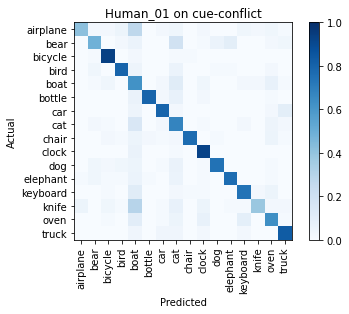

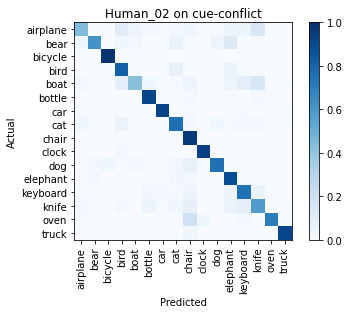

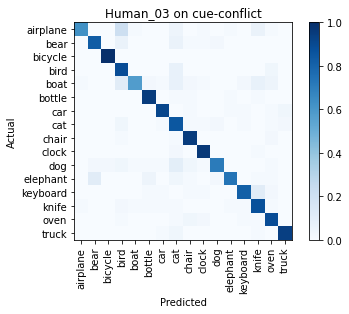

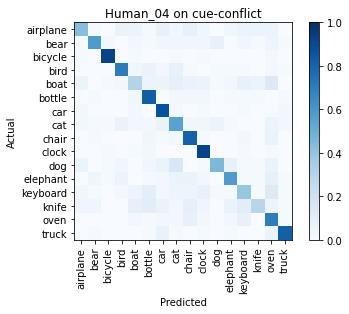

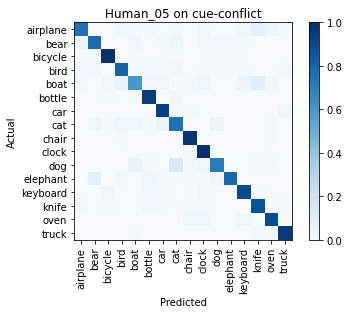

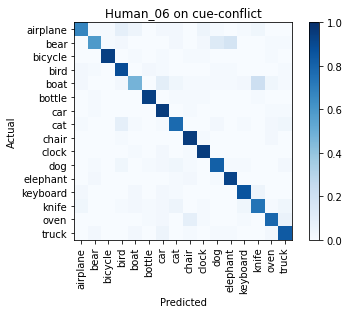

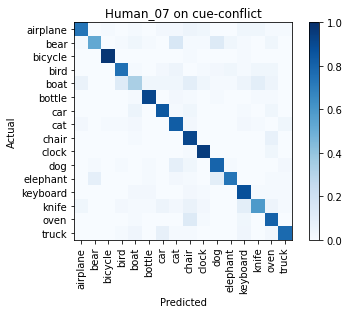

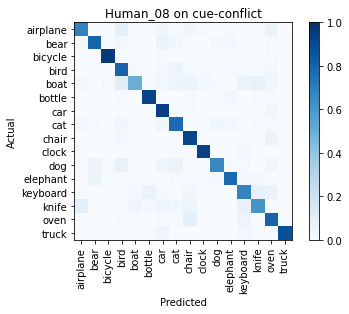

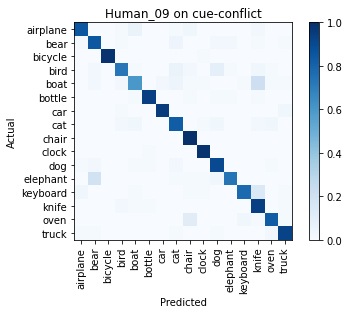

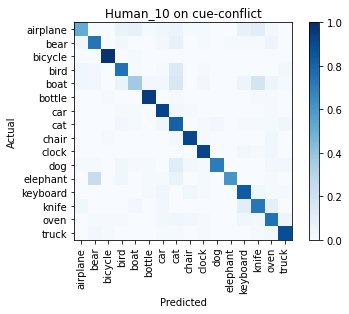

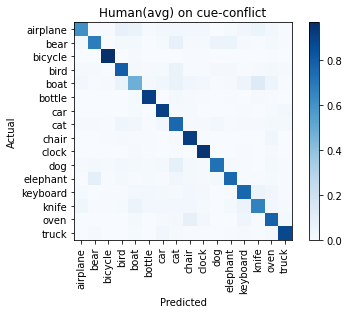

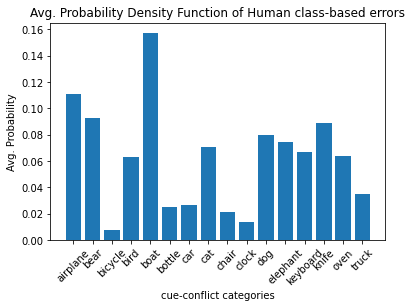

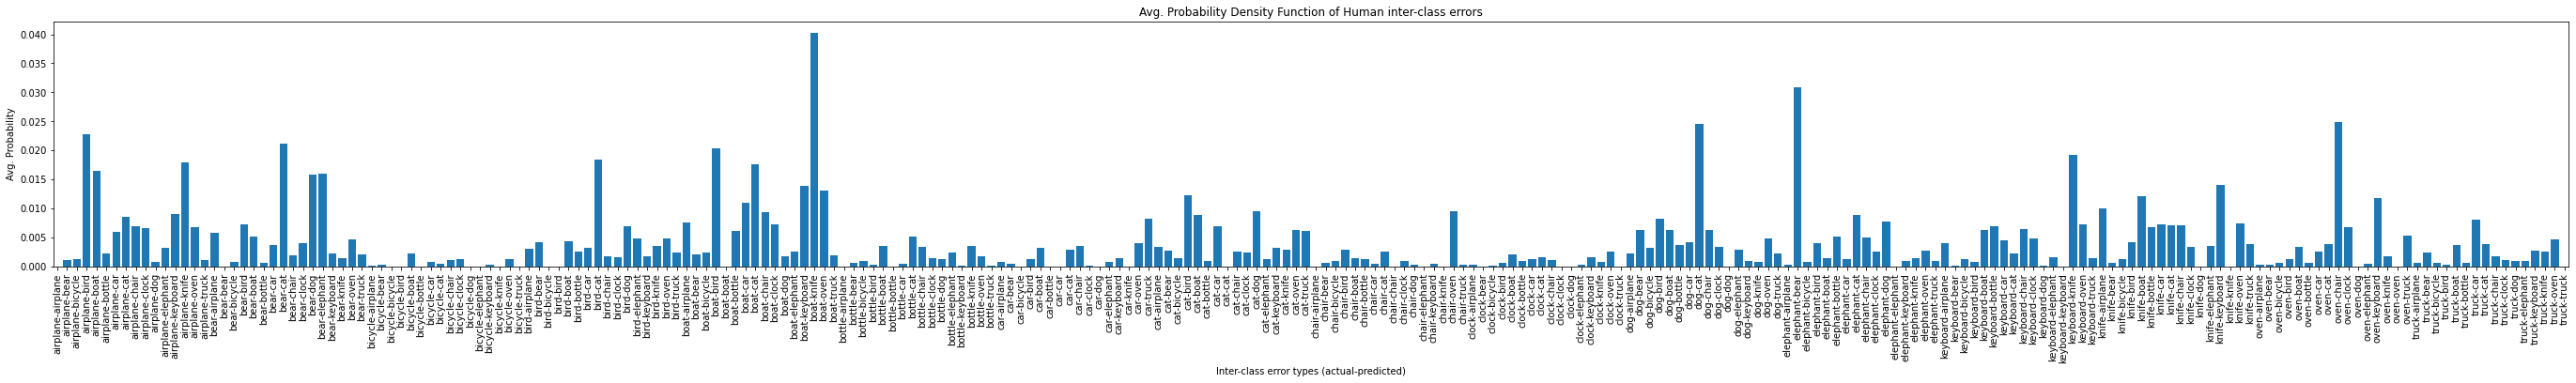

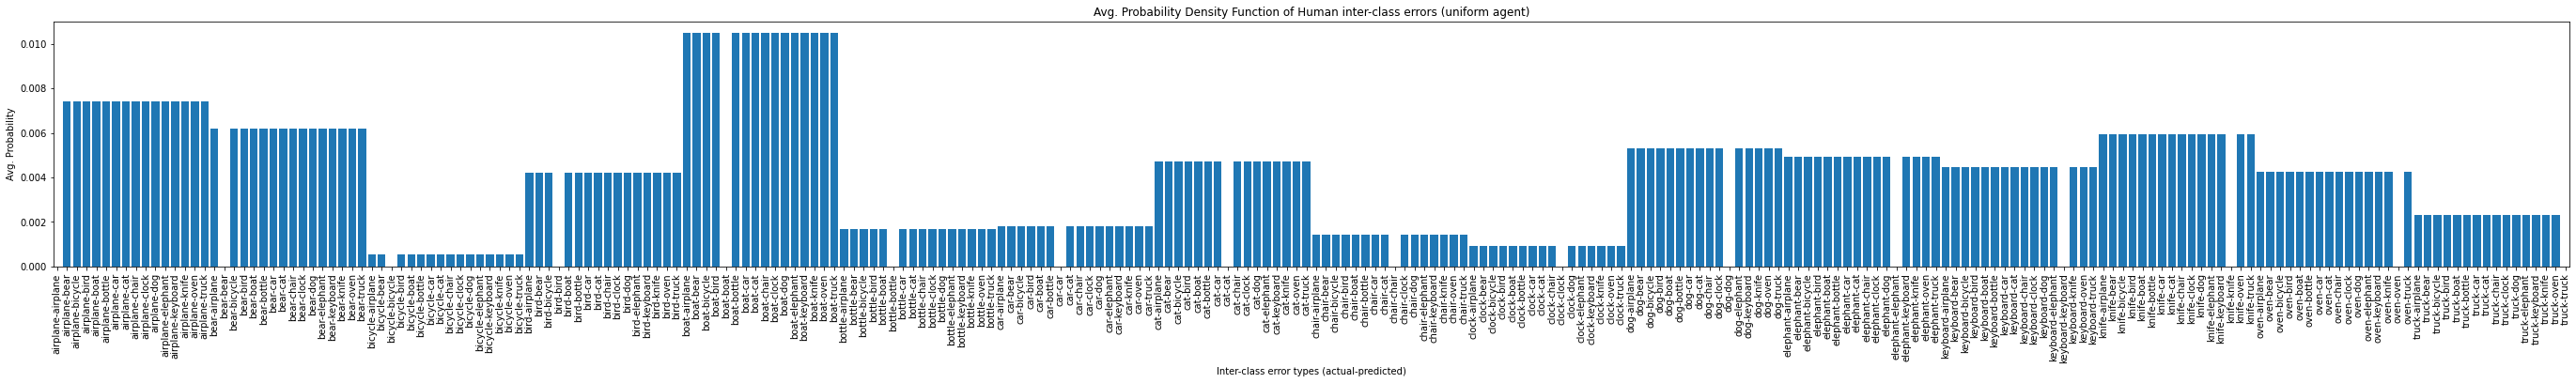

In [5]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
uniform_inter_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  uniform_inter_pdf_list.append(uniform_inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
uniform_inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
  uniform_inter_pdf_avg += uniform_inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)
uniform_inter_pdf_avg = np.divide(uniform_inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

human_class_pdf_list = class_pdf_list
human_inter_pdf_list = inter_pdf_list
human_uniform_inter_pdf_list = uniform_inter_pdf_list

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], uniform_inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors (uniform agent)')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [6]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


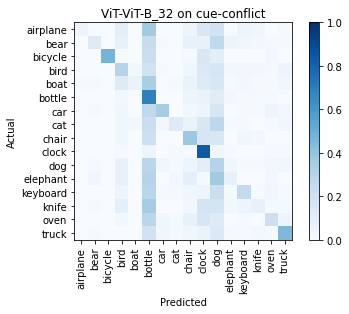

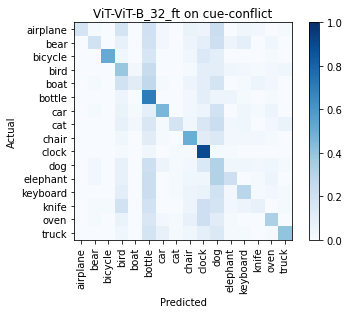

In [7]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = {'ViT-B_32': 'ViT-B/32', 'ViT-B_32_ft': 'ViT-B/32(ft.)'}

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}
js_dist_inter_uniform = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[vit_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[vit_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[vit_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[vit_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[vit_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[vit_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[vit_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[vit_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[vit_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[vit_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[vit_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[vit_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate CNN confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


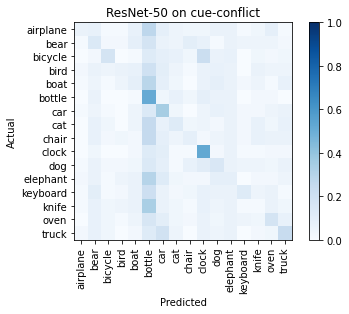

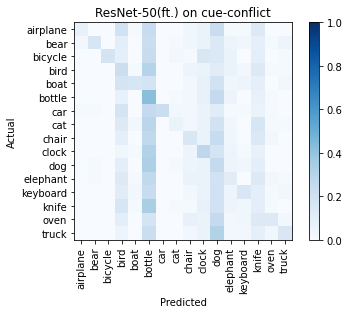

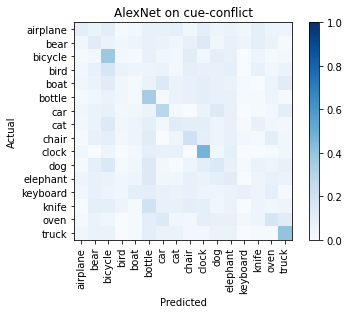

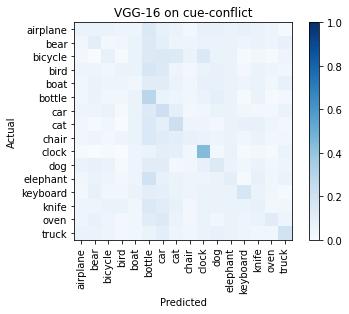

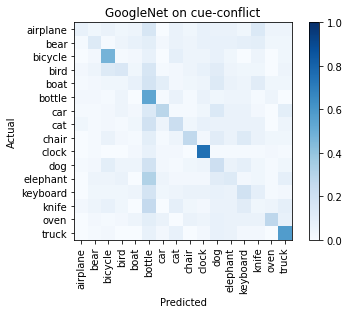

In [8]:
conv_models = {'resnet50': 'ResNet-50', 'resnet50_ft': 'ResNet-50(ft.)', 'alexnet': 'AlexNet', 'vgg16-bn': 'VGG-16', 'inception-v3': 'GoogleNet'}
all_models = vit_models.copy()
all_models.update(conv_models)

for model in conv_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[conv_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[conv_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[conv_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[conv_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[conv_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[conv_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[conv_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[conv_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[conv_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[conv_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[conv_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[conv_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'{conv_models[model]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B/32, 	 KL-Distance: 0.108
Model: ViT-B/32(ft.), 	 KL-Distance: 0.101
Model: ResNet-50, 	 KL-Distance: 0.185
Model: ResNet-50(ft.), 	 KL-Distance: 0.224
Model: AlexNet, 	 KL-Distance: 0.153
Model: VGG-16, 	 KL-Distance: 0.216
Model: GoogleNet, 	 KL-Distance: 0.122


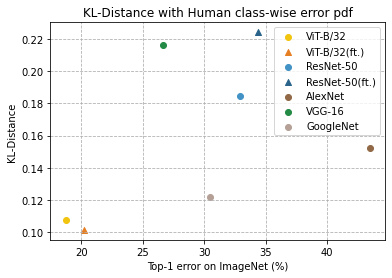

In [9]:
colors_models = {'ViT-B/32': '#F1C40F', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50(ft.)': '#296389', 'ResNet-50': '#4292C6', 'AlexNet': '#916946', 'GoogleNet': '#B4A096', 'VGG-16': '#238b45'}
colors_scatter_ft = {'ViT-B/32': '#E67E22', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50(ft.)': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B/32, 	 KL-Distance: 1.170
Model: ViT-B/32(ft.), 	 KL-Distance: 1.106
Model: ResNet-50, 	 KL-Distance: 0.789
Model: ResNet-50(ft.), 	 KL-Distance: 1.145
Model: AlexNet, 	 KL-Distance: 0.647
Model: VGG-16, 	 KL-Distance: 0.581
Model: GoogleNet, 	 KL-Distance: 0.640


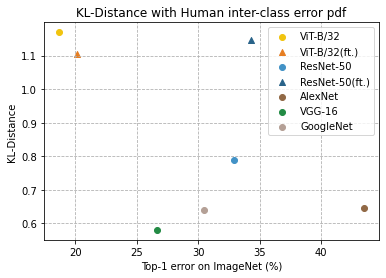

In [10]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B/32, 	 JS-Distance: 0.191
Model: ViT-B/32(ft.), 	 JS-Distance: 0.187
Model: ResNet-50, 	 JS-Distance: 0.227
Model: ResNet-50(ft.), 	 JS-Distance: 0.245
Model: AlexNet, 	 JS-Distance: 0.215
Model: VGG-16, 	 JS-Distance: 0.240
Model: GoogleNet, 	 JS-Distance: 0.199


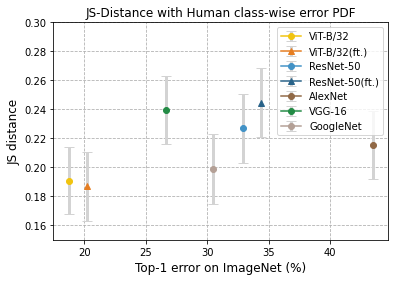

In [11]:
js_dist_class_exp[experiment] = js_dist_class

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.ylim([0.15, 0.3])
plt.legend(loc='upper right')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_class-wise_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human class-wise error PDF')
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B/32, 	 JS-Distance: 0.627
Model: ViT-B/32(ft.), 	 JS-Distance: 0.620
Model: ResNet-50, 	 JS-Distance: 0.578
Model: ResNet-50(ft.), 	 JS-Distance: 0.638
Model: AlexNet, 	 JS-Distance: 0.573
Model: VGG-16, 	 JS-Distance: 0.553
Model: GoogleNet, 	 JS-Distance: 0.562


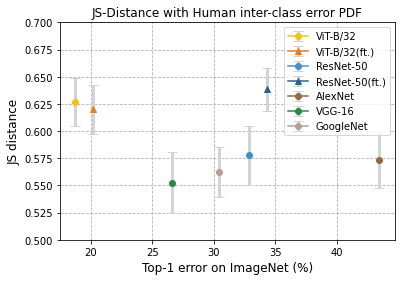

In [12]:
js_dist_inter_exp[experiment] = js_dist_inter

for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_inter[model][0], js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.ylim([0.5, 0.7])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human inter-class error PDF')
plt.show()

### Plot JS distance between misclassifications per class

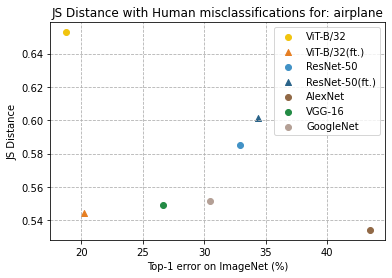

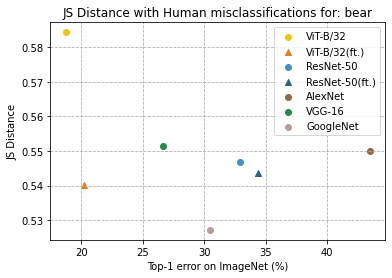

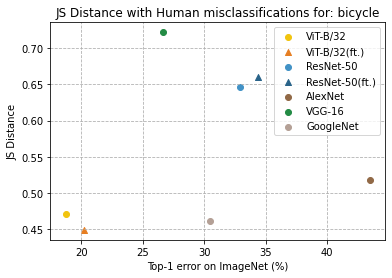

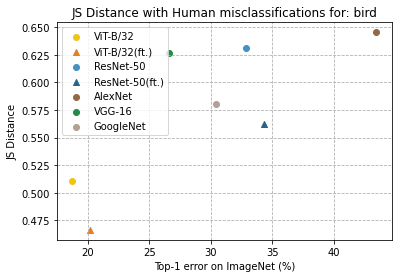

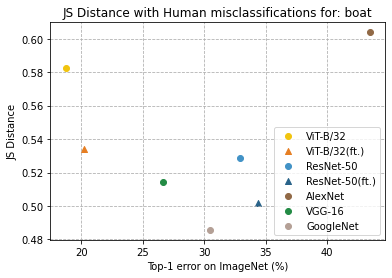

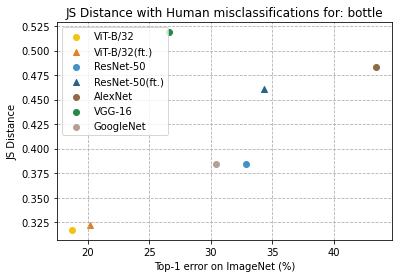

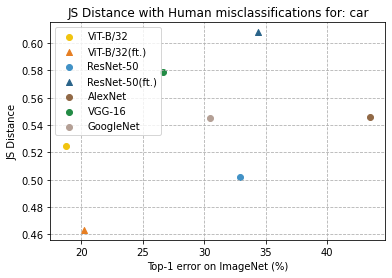

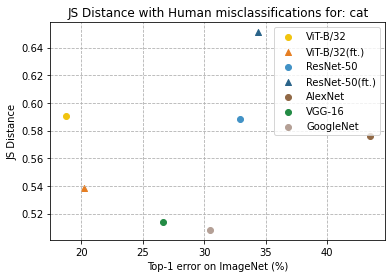

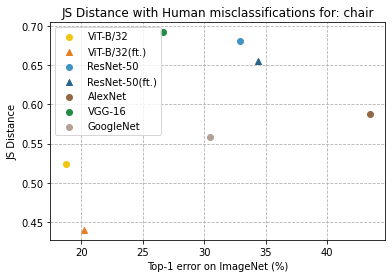

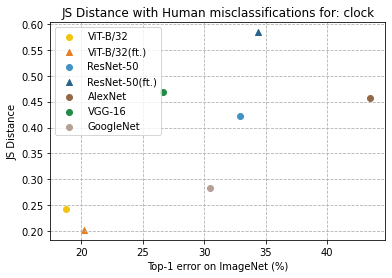

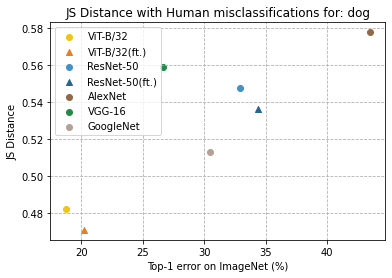

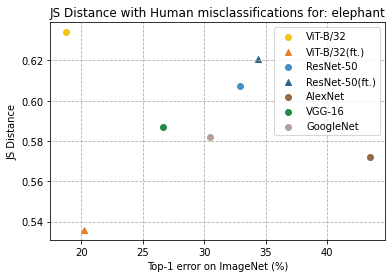

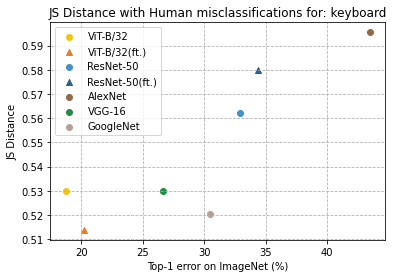

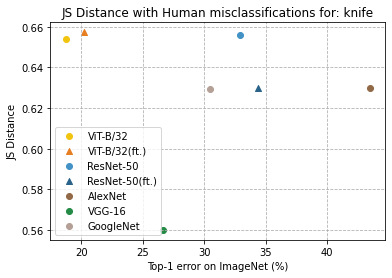

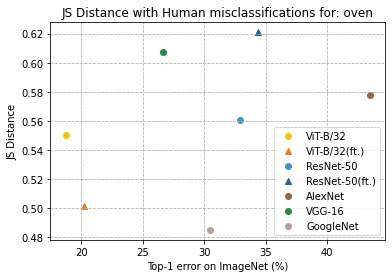

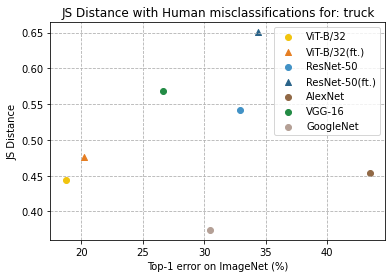

In [13]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  
  plt.grid(linestyle='--')
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

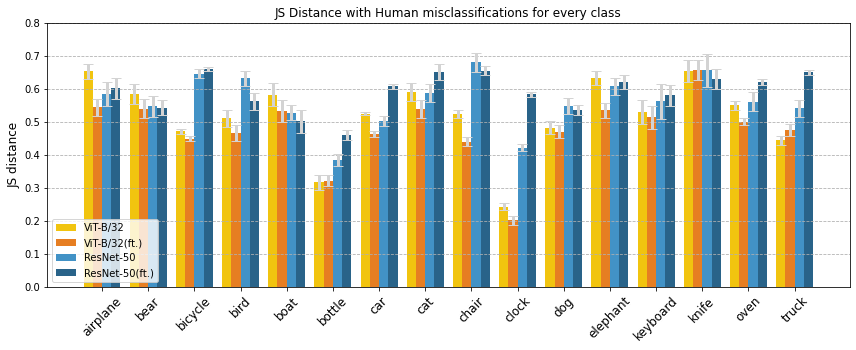

In [14]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  if not (model.startswith('ViT') or model.startswith('ResNet')): continue
  ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], width, label=model, color=colors_models[model])
  ax.errorbar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], fmt='none', yerr=[js_misclassification[model][cat][1] for cat in categories_SIN], capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN, fontsize=12)
ax.legend()
ax.set_ylim([0, 0.8])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_misclassifications_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('JS Distance with Human misclassifications for every class')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B/32, 	 JS-Distance: 0.191, 	 Cohen's Kappa: 0.137
Model: ViT-B/32(ft.), 	 JS-Distance: 0.187, 	 Cohen's Kappa: 0.156
Model: ResNet-50, 	 JS-Distance: 0.227, 	 Cohen's Kappa: 0.068
Model: ResNet-50(ft.), 	 JS-Distance: 0.245, 	 Cohen's Kappa: 0.030
Model: AlexNet, 	 JS-Distance: 0.215, 	 Cohen's Kappa: 0.080
Model: VGG-16, 	 JS-Distance: 0.240, 	 Cohen's Kappa: 0.042
Model: GoogleNet, 	 JS-Distance: 0.199, 	 Cohen's Kappa: 0.120


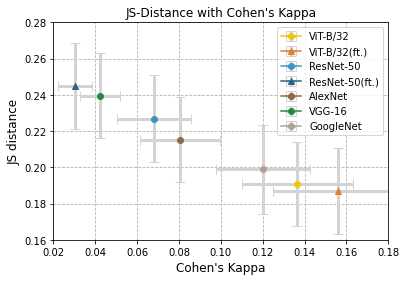

In [15]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

for model in js_dist_class.keys():
  plt.errorbar(cohens_k[model][0], js_dist_class[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  # plt.scatter(cohens_k[model][0], js_dist_class[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel('Cohen\'s Kappa', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.xlim([0.02, 0.18])
plt.ylim([0.16, 0.28])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot all metrics (all models)



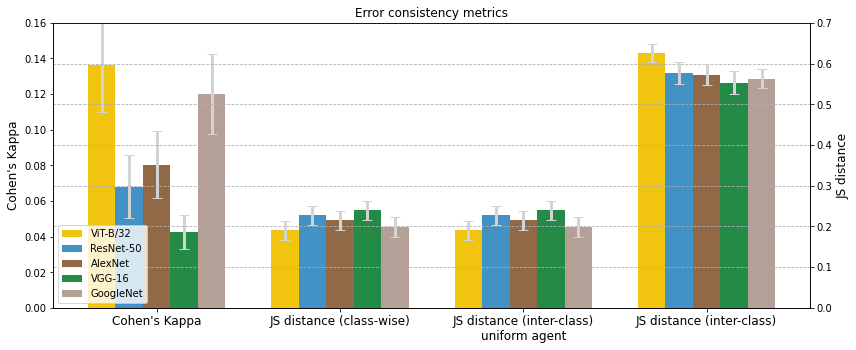

In [16]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if model.endswith('(ft.)'): continue
  ax.bar(x[0] - 4*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 4*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.16])
ax2.set_ylim([0, 0.7])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

### Plot all metrics (fine-tuning)



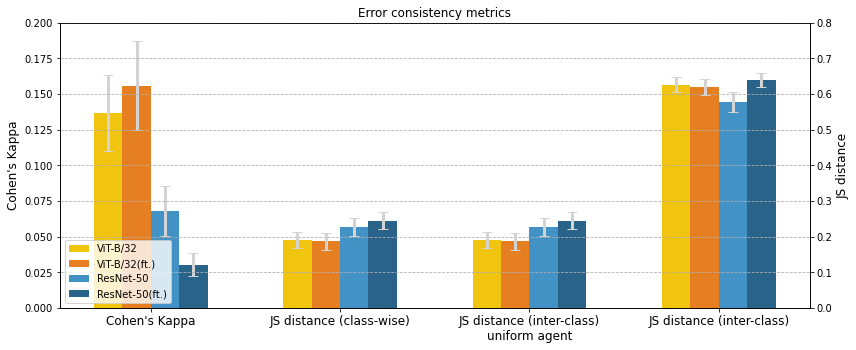

In [17]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if (model.startswith('VGG') or model.startswith('Alex') or model.startswith('Google')): continue
  ax.bar(x[0] - 3*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 3*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.2])
# ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))
ax2.set_ylim([0, 0.8])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}_ft.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

## Experiment 2: Edges


In [18]:
experiment = 'edges'

### Generate Human confusion matrices

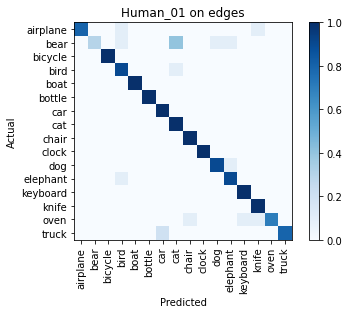

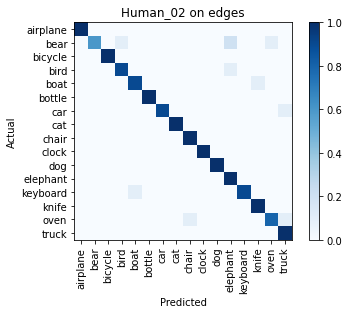

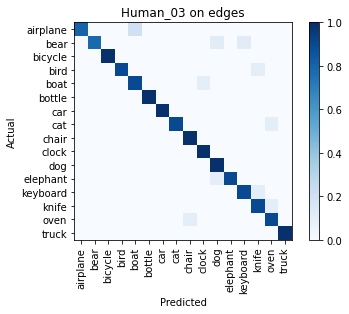

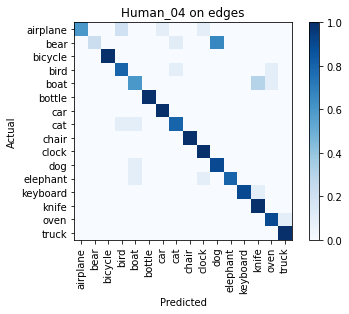

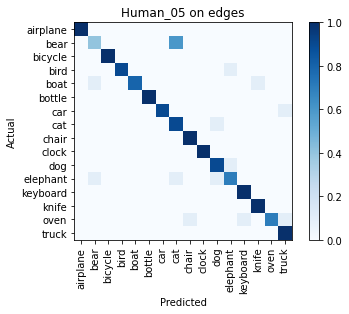

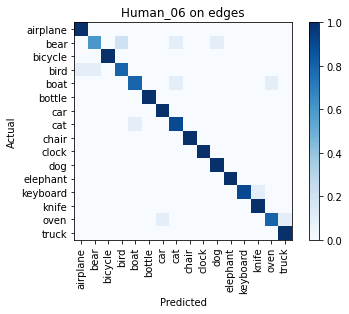

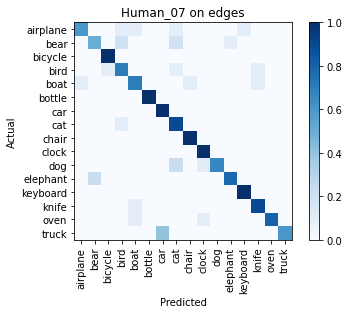

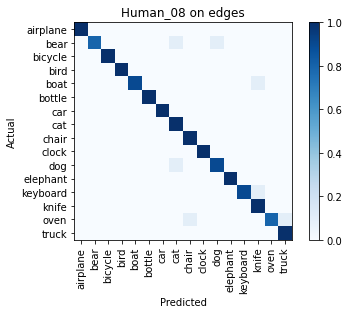

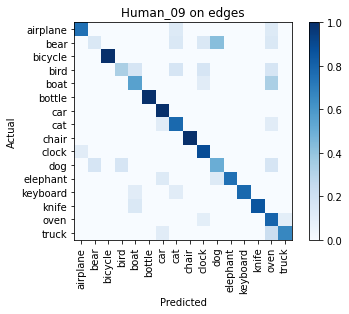

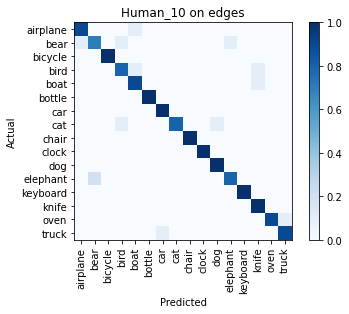

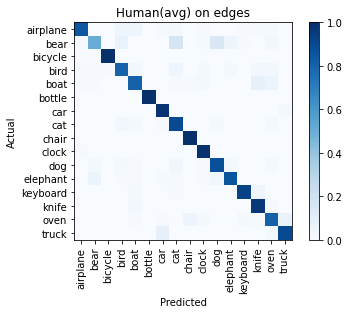

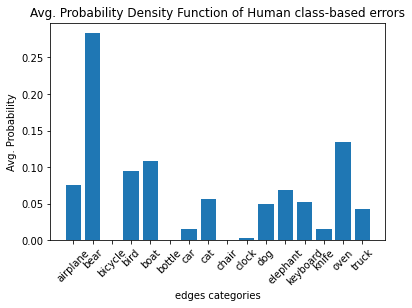

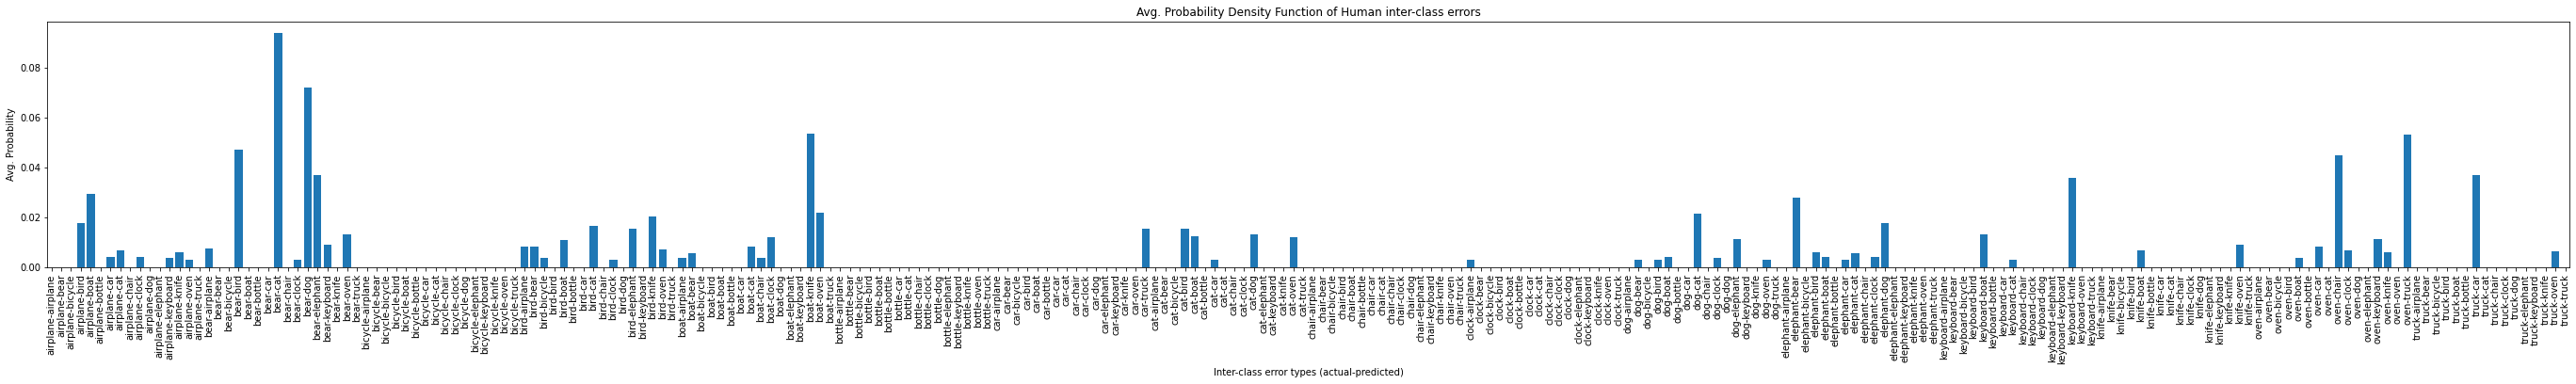

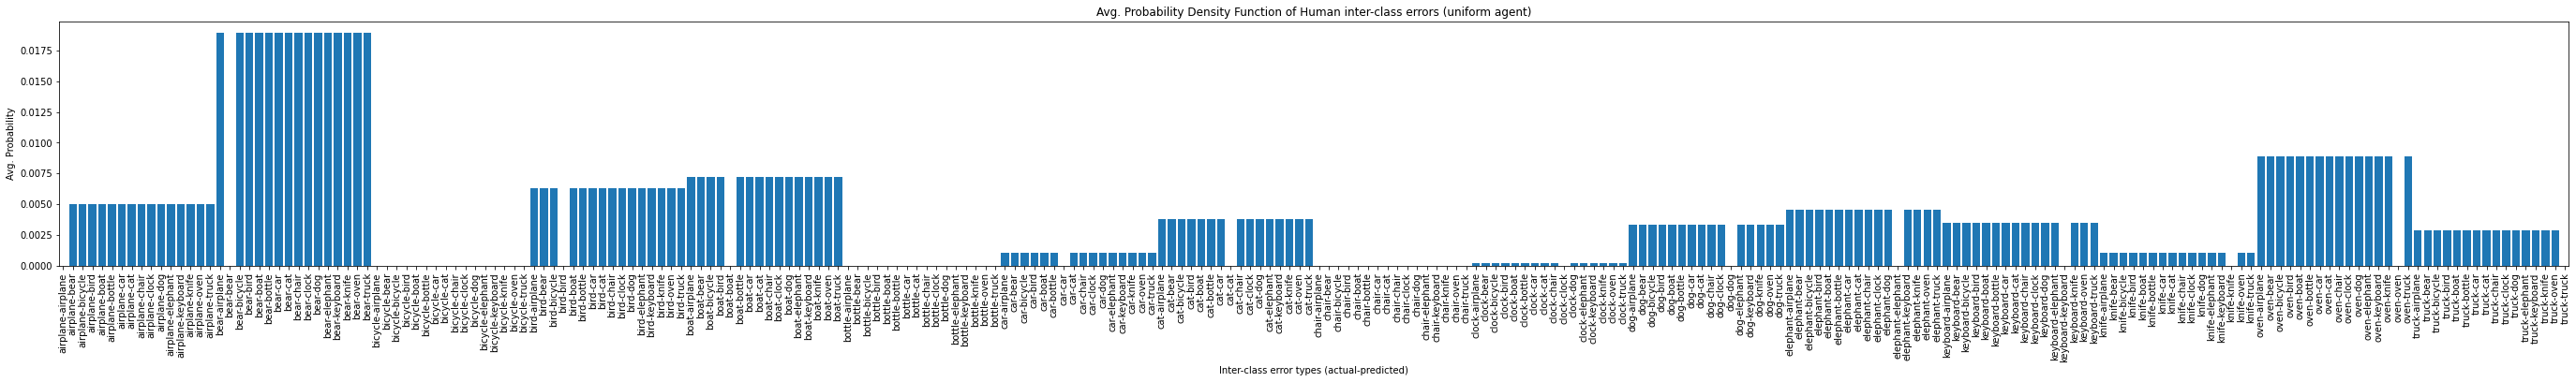

In [19]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
uniform_inter_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  uniform_inter_pdf_list.append(uniform_inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
uniform_inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
  uniform_inter_pdf_avg += uniform_inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)
uniform_inter_pdf_avg = np.divide(uniform_inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

human_class_pdf_list = class_pdf_list
human_inter_pdf_list = inter_pdf_list
human_uniform_inter_pdf_list = uniform_inter_pdf_list

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], uniform_inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors (uniform agent)')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [20]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


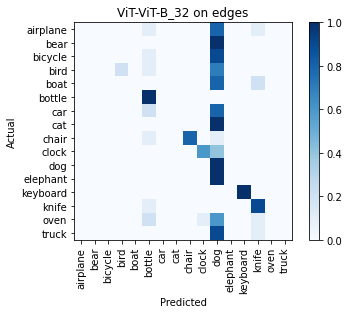

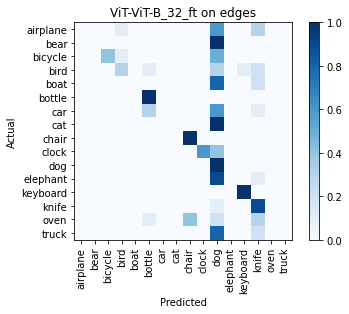

In [21]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = {'ViT-B_32': 'ViT-B/32', 'ViT-B_32_ft': 'ViT-B/32(ft.)'}

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}
js_dist_inter_uniform = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[vit_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[vit_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[vit_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[vit_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[vit_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[vit_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[vit_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[vit_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[vit_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[vit_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[vit_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[vit_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate CNN confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


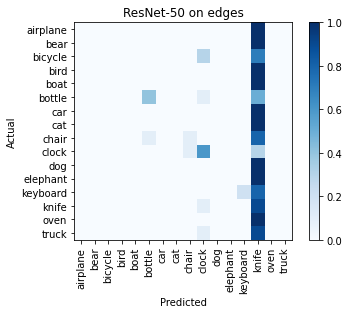

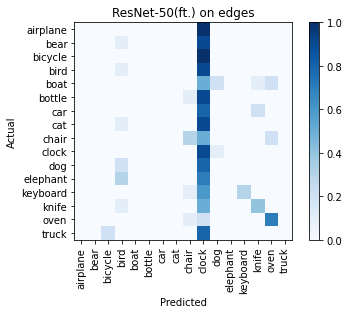

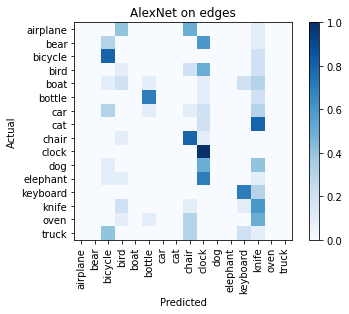

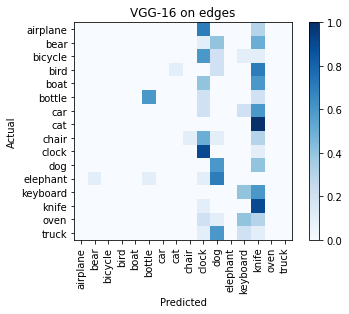

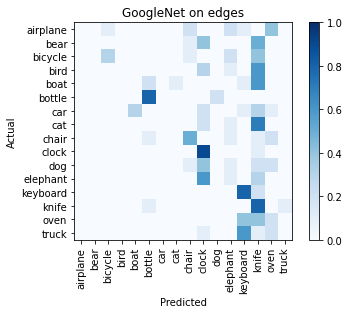

In [22]:
conv_models = {'resnet50': 'ResNet-50', 'resnet50_ft': 'ResNet-50(ft.)', 'alexnet': 'AlexNet', 'vgg16-bn': 'VGG-16', 'inception-v3': 'GoogleNet'}
all_models = vit_models.copy()
all_models.update(conv_models)

for model in conv_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[conv_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[conv_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[conv_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[conv_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[conv_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[conv_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[conv_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[conv_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[conv_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[conv_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[conv_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[conv_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'{conv_models[model]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B/32, 	 KL-Distance: 0.277
Model: ViT-B/32(ft.), 	 KL-Distance: 0.354
Model: ResNet-50, 	 KL-Distance: 0.069
Model: ResNet-50(ft.), 	 KL-Distance: 0.084
Model: AlexNet, 	 KL-Distance: 0.184
Model: VGG-16, 	 KL-Distance: 0.030
Model: GoogleNet, 	 KL-Distance: 0.128


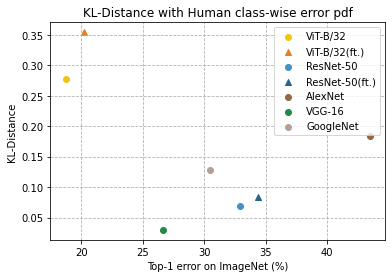

In [23]:
colors_models = {'ViT-B/32': '#F1C40F', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50(ft.)': '#296389', 'ResNet-50': '#4292C6', 'AlexNet': '#916946', 'GoogleNet': '#B4A096', 'VGG-16': '#238b45'}
colors_scatter_ft = {'ViT-B/32': '#E67E22', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50(ft.)': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B/32, 	 KL-Distance: 0.367
Model: ViT-B/32(ft.), 	 KL-Distance: 0.467
Model: ResNet-50, 	 KL-Distance: 0.506
Model: ResNet-50(ft.), 	 KL-Distance: 0.992
Model: AlexNet, 	 KL-Distance: 0.621
Model: VGG-16, 	 KL-Distance: 0.391
Model: GoogleNet, 	 KL-Distance: 0.609


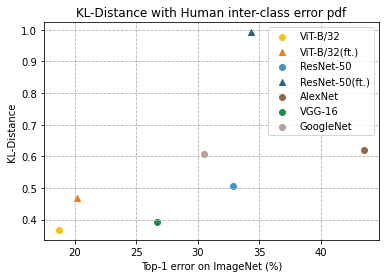

In [24]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B/32, 	 JS-Distance: 0.460
Model: ViT-B/32(ft.), 	 JS-Distance: 0.443
Model: ResNet-50, 	 JS-Distance: 0.463
Model: ResNet-50(ft.), 	 JS-Distance: 0.486
Model: AlexNet, 	 JS-Distance: 0.413
Model: VGG-16, 	 JS-Distance: 0.454
Model: GoogleNet, 	 JS-Distance: 0.438


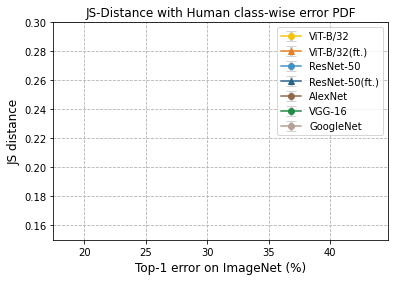

In [25]:
js_dist_class_exp[experiment] = js_dist_class

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.ylim([0.15, 0.3])
plt.legend(loc='upper right')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_class-wise_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human class-wise error PDF')
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B/32, 	 JS-Distance: 0.778
Model: ViT-B/32(ft.), 	 JS-Distance: 0.755
Model: ResNet-50, 	 JS-Distance: 0.786
Model: ResNet-50(ft.), 	 JS-Distance: 0.796
Model: AlexNet, 	 JS-Distance: 0.782
Model: VGG-16, 	 JS-Distance: 0.754
Model: GoogleNet, 	 JS-Distance: 0.782


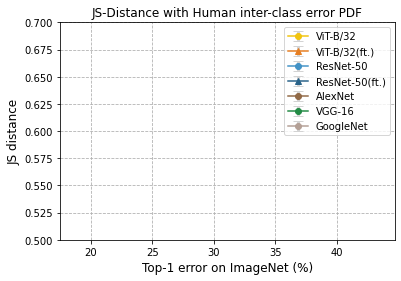

In [26]:
js_dist_inter_exp[experiment] = js_dist_inter

for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_inter[model][0], js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.ylim([0.5, 0.7])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human inter-class error PDF')
plt.show()

### Plot JS distance between misclassifications per class

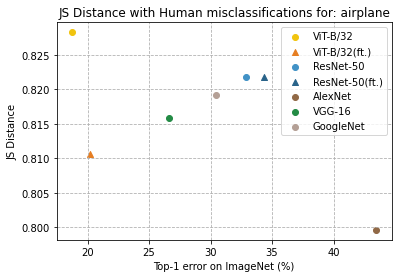

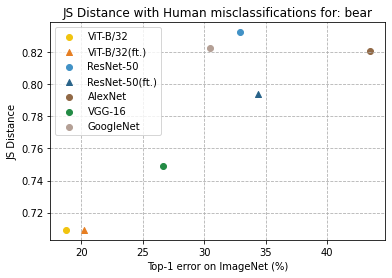

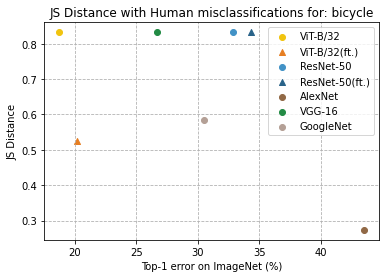

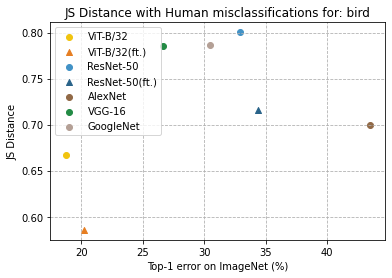

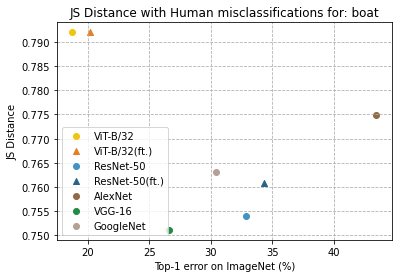

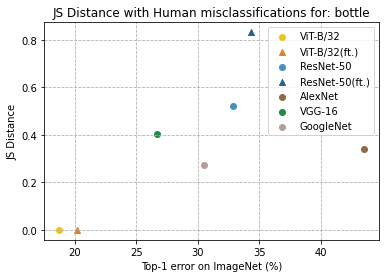

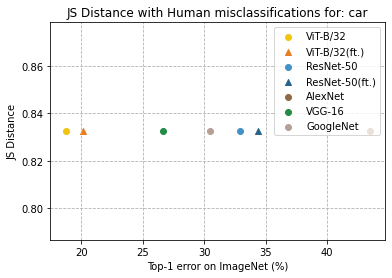

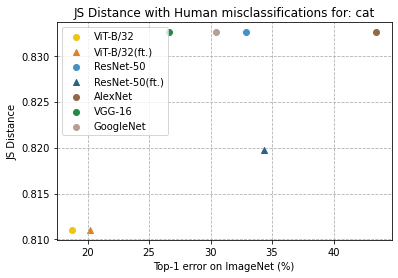

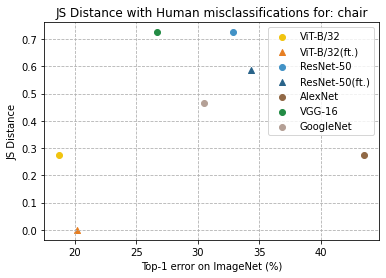

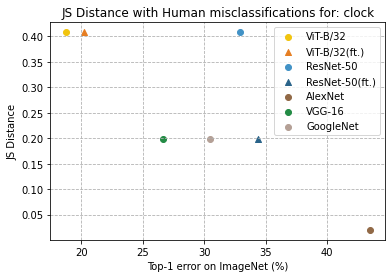

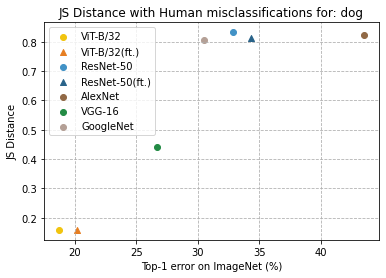

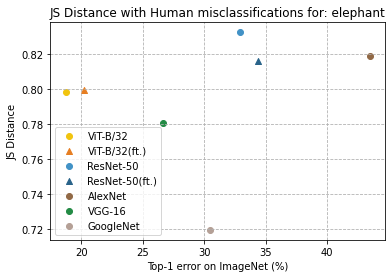

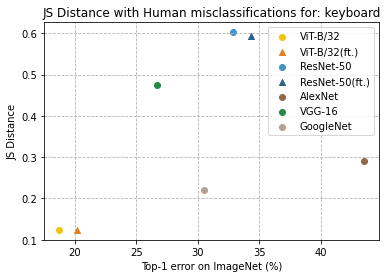

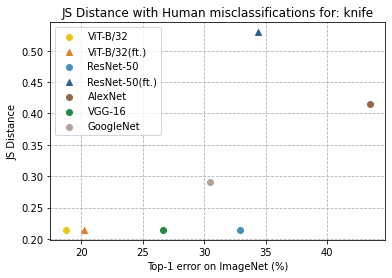

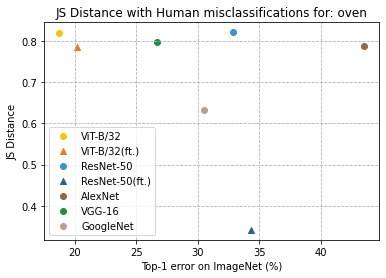

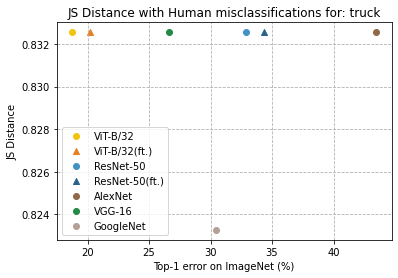

In [27]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  
  plt.grid(linestyle='--')
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

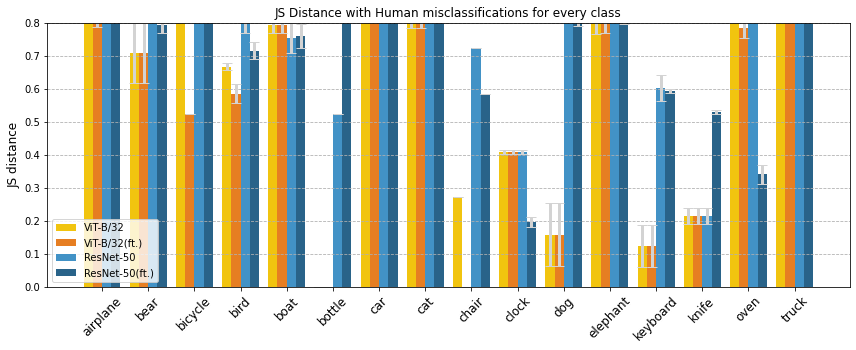

In [28]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  if not (model.startswith('ViT') or model.startswith('ResNet')): continue
  ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], width, label=model, color=colors_models[model])
  ax.errorbar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], fmt='none', yerr=[js_misclassification[model][cat][1] for cat in categories_SIN], capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN, fontsize=12)
ax.legend()
ax.set_ylim([0, 0.8])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_misclassifications_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('JS Distance with Human misclassifications for every class')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B/32, 	 JS-Distance: 0.460, 	 Cohen's Kappa: 0.075
Model: ViT-B/32(ft.), 	 JS-Distance: 0.443, 	 Cohen's Kappa: 0.086
Model: ResNet-50, 	 JS-Distance: 0.463, 	 Cohen's Kappa: 0.036
Model: ResNet-50(ft.), 	 JS-Distance: 0.486, 	 Cohen's Kappa: 0.013
Model: AlexNet, 	 JS-Distance: 0.413, 	 Cohen's Kappa: 0.098
Model: VGG-16, 	 JS-Distance: 0.454, 	 Cohen's Kappa: 0.043
Model: GoogleNet, 	 JS-Distance: 0.438, 	 Cohen's Kappa: 0.078


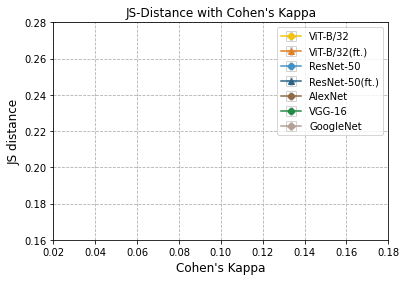

In [29]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

for model in js_dist_class.keys():
  plt.errorbar(cohens_k[model][0], js_dist_class[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  # plt.scatter(cohens_k[model][0], js_dist_class[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel('Cohen\'s Kappa', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.xlim([0.02, 0.18])
plt.ylim([0.16, 0.28])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot all metrics (all models)



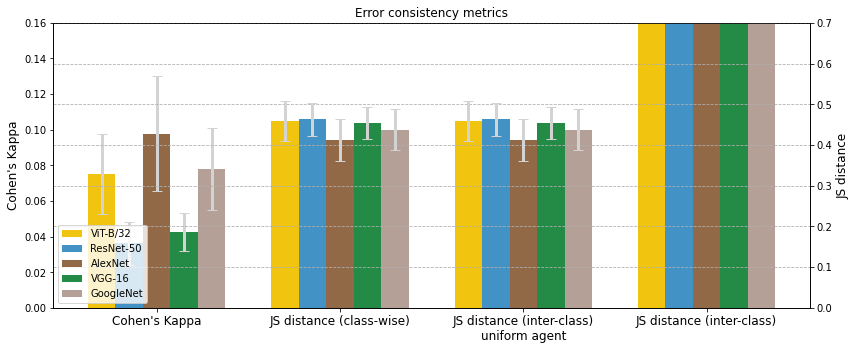

In [30]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if model.endswith('(ft.)'): continue
  ax.bar(x[0] - 4*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 4*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.16])
ax2.set_ylim([0, 0.7])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

### Plot all metrics (fine-tuning)



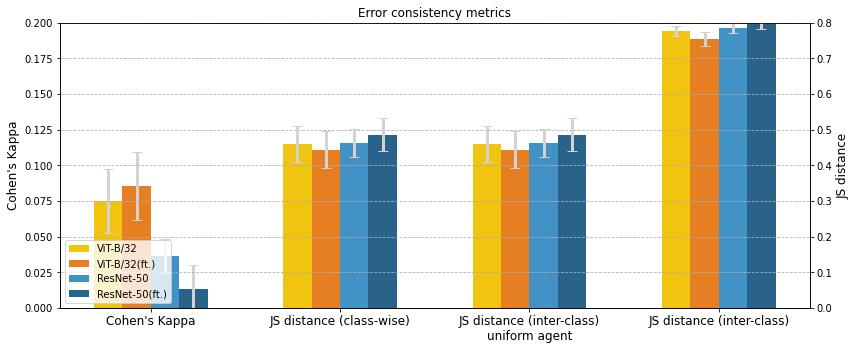

In [31]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if (model.startswith('VGG') or model.startswith('Alex') or model.startswith('Google')): continue
  ax.bar(x[0] - 3*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 3*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.2])
# ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))
ax2.set_ylim([0, 0.8])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}_ft.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

## Experiment 3: Silhouettes


In [32]:
experiment = 'silhouettes'

### Generate Human confusion matrices

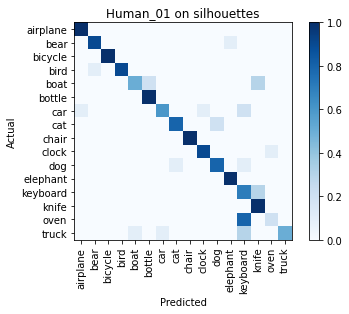

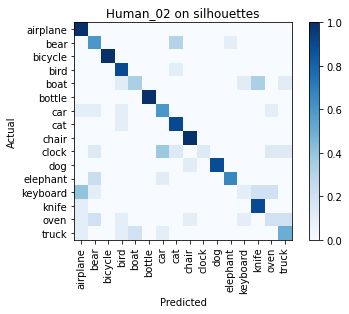

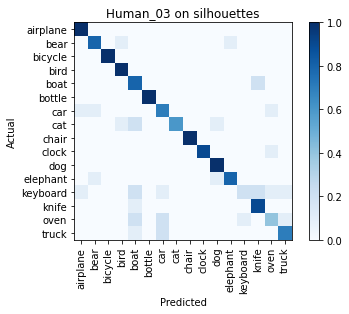

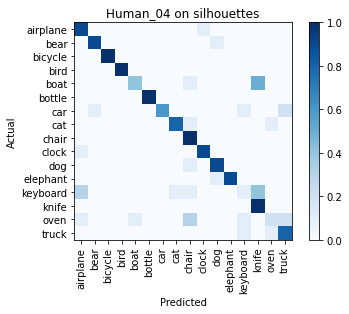

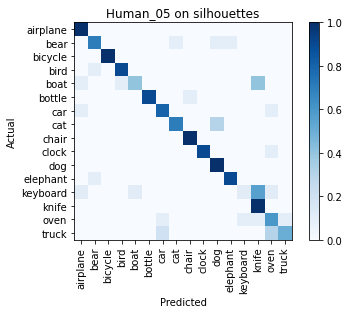

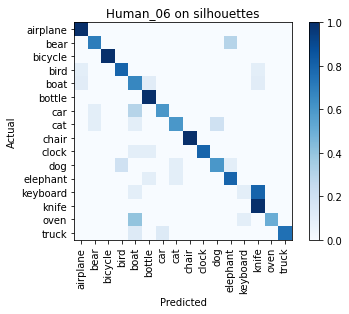

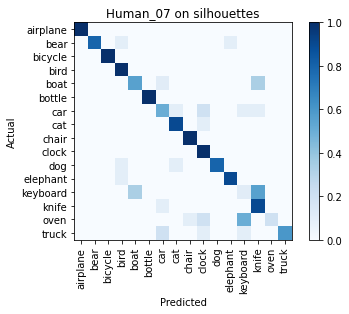

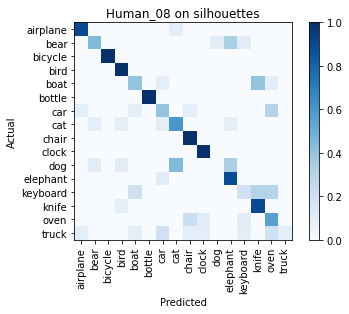

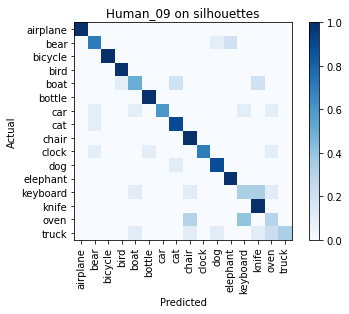

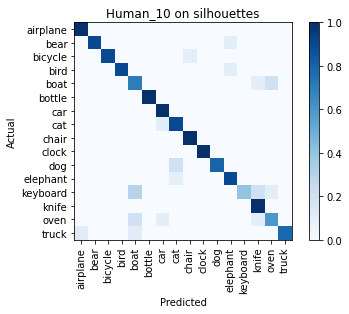

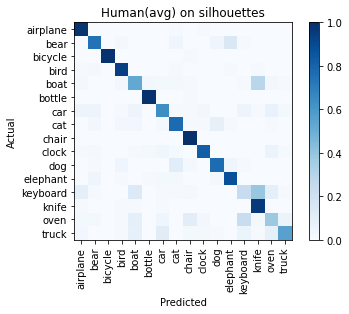

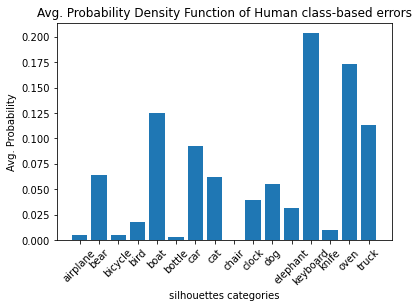

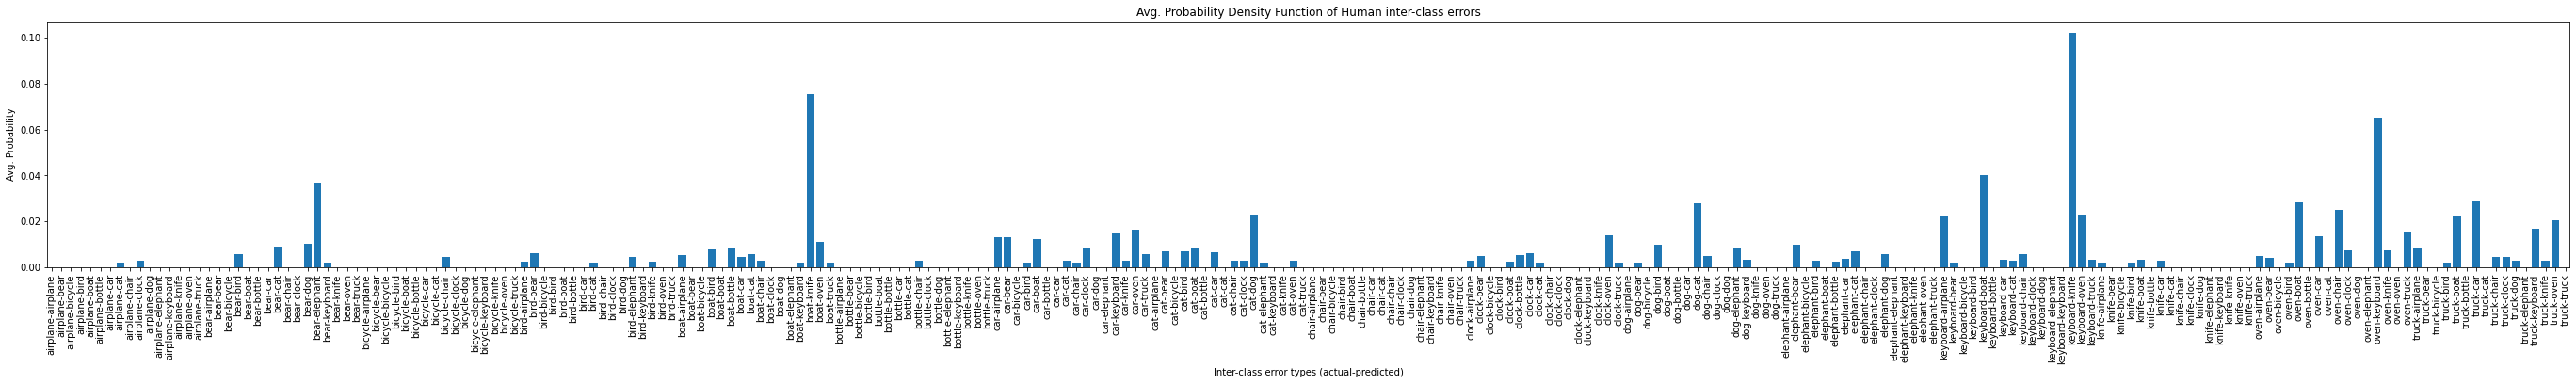

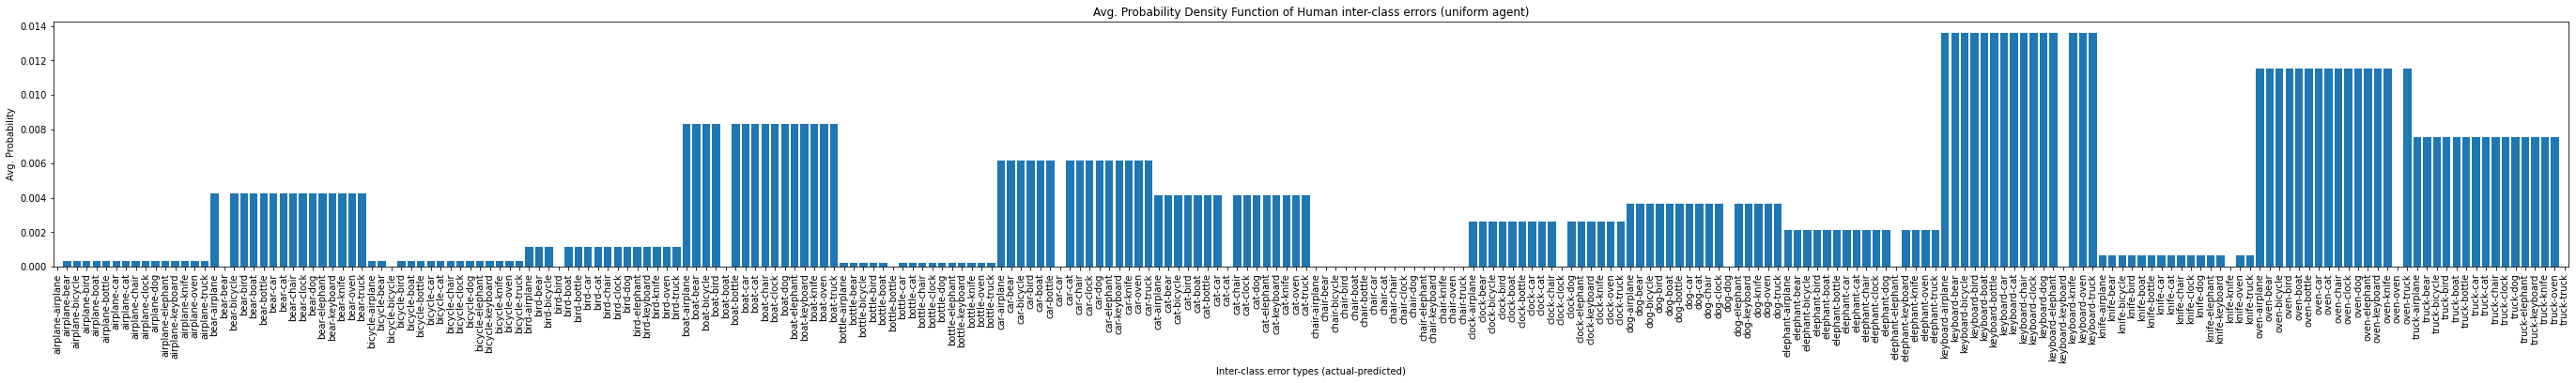

In [33]:
categories_SIN = os.listdir('../../texture-vs-shape/stimuli/style-transfer-preprocessed-512/')
categories_SIN.sort()

class_pdf_list = []
uniform_inter_pdf_list = []
inter_pdf_list = []
misclassification_human = {}
cm_norm_list = []
cm_norm_dict = {}

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = 0

for sub in range(1, 11):
  str_sub = '0'+str(sub) if sub < 10 else str(sub)
  human_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_subject-{str_sub}_session_1.csv')
  pred = human_csv['object_response']
  true = human_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_list.append(cm_norm)

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  for i in range(len(categories_SIN)):
    misclassification_human[categories_SIN[i]] += cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  class_pdf_list.append(class_pdf_errors)
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)
  inter_pdf_list.append(inter_pdf_errors)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  uniform_inter_pdf_list.append(uniform_inter_pdf_errors)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'Human_{str_sub} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

class_pdf_avg = np.zeros_like(class_pdf_errors)
inter_pdf_avg = np.zeros_like(inter_pdf_errors)
uniform_inter_pdf_avg = np.zeros_like(inter_pdf_errors)
cm_norm_avg = np.zeros_like(cm_norm)
for i in range(10):
  class_pdf_avg += class_pdf_list[i]
  cm_norm_avg += cm_norm_list[i]
class_pdf_avg = np.divide(class_pdf_avg, 10)
cm_norm_avg = np.divide(cm_norm_avg, 10)

for i in range(10):
  inter_pdf_avg += inter_pdf_list[i]
  uniform_inter_pdf_avg += uniform_inter_pdf_list[i]
inter_pdf_avg = np.divide(inter_pdf_avg, 10)
uniform_inter_pdf_avg = np.divide(uniform_inter_pdf_avg, 10)

for i in range(len(categories_SIN)):
  misclassification_human[categories_SIN[i]] = np.divide(misclassification_human[categories_SIN[i]], 10)

human_class_pdf = class_pdf_avg
human_inter_pdf = inter_pdf_avg

human_class_pdf_list = class_pdf_list
human_inter_pdf_list = inter_pdf_list
human_uniform_inter_pdf_list = uniform_inter_pdf_list

cm_norm_dict['Human_avg'] = cm_norm_avg

fig, ax = plt.subplots()
plt.imshow(cm_norm_avg, cmap = 'Blues')
plt.title(f'Human(avg) on {experiment}')
plt.colorbar()
ax.set_xticks(np.arange(16))
ax.set_yticks(np.arange(16))
ax.set_xticklabels(categories_SIN, rotation=90)
ax.set_yticklabels(categories_SIN)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')

fig = plt.figure()
plt.bar(categories_SIN, class_pdf_avg)
plt.xticks(rotation = 45)
plt.xlabel(f'{experiment} categories')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human class-based errors')
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors')
plt.margins(x=0,tight=True)
plt.show()

fig = plt.figure(figsize=[48, 4.8])
plt.bar([str(c1+'-'+c2) for c1, c2 in itertools.product(categories_SIN, categories_SIN)], uniform_inter_pdf_avg)
plt.xticks(rotation = 90)
plt.xlabel('Inter-class error types (actual-predicted)')
plt.ylabel('Avg. Probability')
plt.title('Avg. Probability Density Function of Human inter-class errors (uniform agent)')
plt.margins(x=0,tight=True)
plt.show()

### Define distance metric

In [34]:
def kl_distance(p, q):
  non_zero_indices = np.intersect1d(np.where(p!=0)[0], np.where(q!=0)[0])
  return np.sum([p[i] * np.log(p[i] / q[i]) for i in non_zero_indices])

def cross_entropy(p, q):
	return -np.sum(np.where(p != 0, p * np.log(q), 0))
 
def mse(p, q):
  return np.square(np.subtract(p,q)).mean() 

def js_distance(p, q):
  return jensenshannon(p, q)

### Generate ViT confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


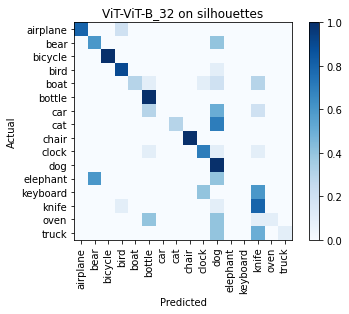

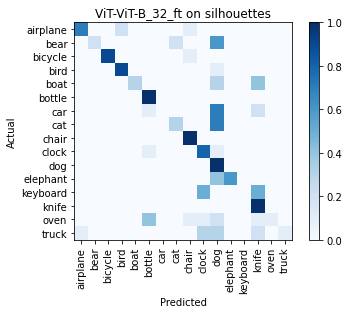

In [35]:
# vit_models = ['B_32', 'B_16', 'L_32', 'L_16', 'B_32_ft']
vit_models = {'ViT-B_32': 'ViT-B/32', 'ViT-B_32_ft': 'ViT-B/32(ft.)'}

kl_dist_class = {}
kl_dist_inter = {}

ce_dist_class = {}
ce_dist_inter = {}

js_dist_class = {}
js_dist_inter = {}
js_dist_inter_uniform = {}

mse_misclassification = {}
js_misclassification = {}

acc_exp = {}

for model in vit_models:
  vit_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = vit_csv['object_response']
  true = vit_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[vit_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[vit_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[vit_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[vit_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[vit_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[vit_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[vit_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[vit_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[vit_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[vit_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[vit_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[vit_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[vit_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'ViT-{model} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Generate CNN confusion matrices

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in multiply
  


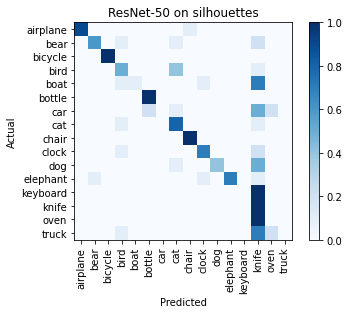

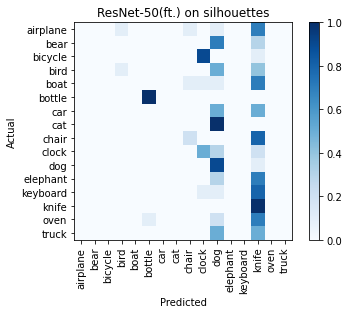

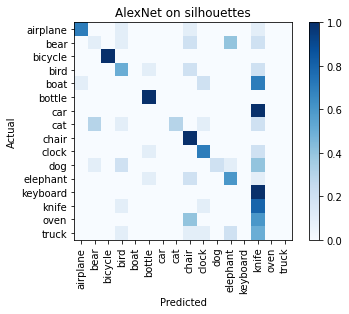

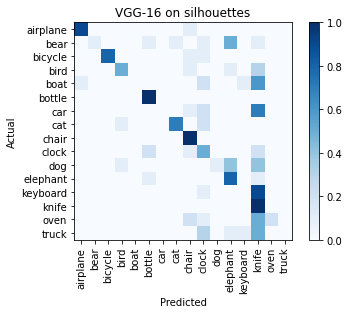

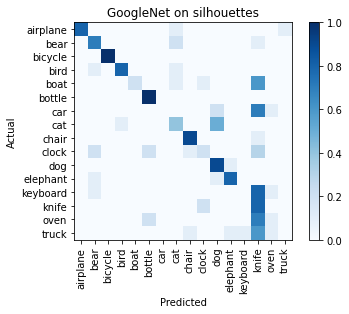

In [36]:
conv_models = {'resnet50': 'ResNet-50', 'resnet50_ft': 'ResNet-50(ft.)', 'alexnet': 'AlexNet', 'vgg16-bn': 'VGG-16', 'inception-v3': 'GoogleNet'}
all_models = vit_models.copy()
all_models.update(conv_models)

for model in conv_models:
  resnet_csv = pd.read_csv(f'./texture-shape_{experiment}/texture-shape_{experiment}_{model}_session-1.csv')
  pred = resnet_csv['object_response']
  true = resnet_csv['category']

  cm = confusion_matrix(true, pred, labels = categories_SIN)
  cm_norm = confusion_matrix(true, pred, labels = categories_SIN, normalize = 'true')

  cm_norm_dict[conv_models[model]] = cm_norm

  cm_errors = np.copy(cm)
  np.fill_diagonal(cm_errors, 0)

  misclassification_error = {}

  for i in range(len(categories_SIN)):
    misclassification_error[categories_SIN[i]] = cm_errors[i, [j for j in range(len(categories_SIN)) if j != i]]

  mse_misclassification[conv_models[model]] = {category:mse(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}
  # js_misclassification[conv_models[model]] = {category:js_distance(misclassification_error[category], misclassification_human[category]) for category in categories_SIN}

  js_misclassification[conv_models[model]] = {}
  for i in range(len(categories_SIN)):
    js_misclassification[conv_models[model]][categories_SIN[i]] = mean_confidence_interval([js_distance(cm_norm[i, :], cm_human[i, :]) for cm_human in cm_norm_list])

  class_pdf_errors = np.sum(cm_errors, axis = 1)
  class_pdf_errors = np.divide(class_pdf_errors, np.sum(class_pdf_errors))
  inter_pdf_errors = np.divide(cm_errors, np.sum(cm_errors)).reshape(-1)

  uniform_inter_pdf_errors = np.copy(inter_pdf_errors)
  for i in range(16):
    class_mean = np.sum(inter_pdf_errors[i*16:(i+1)*16])/15
    test_class_pdf = [class_mean for _ in range(16)]
    test_class_pdf[i] = 0
    uniform_inter_pdf_errors[i*16:(i+1)*16] = test_class_pdf

  kl_dist_class[conv_models[model]] = kl_distance(class_pdf_errors, human_class_pdf)
  kl_dist_inter[conv_models[model]] = kl_distance(inter_pdf_errors, human_inter_pdf)

  ce_dist_class[conv_models[model]] = cross_entropy(class_pdf_errors, human_class_pdf)
  ce_dist_inter[conv_models[model]] = cross_entropy(inter_pdf_errors, human_inter_pdf)

  js_dist_class[conv_models[model]] = mean_confidence_interval([js_distance(class_pdf_errors, human_class) for human_class in human_class_pdf_list])
  js_dist_inter[conv_models[model]] = mean_confidence_interval([js_distance(inter_pdf_errors, human_inter) for human_inter in human_inter_pdf_list])
  js_dist_inter_uniform[conv_models[model]] = mean_confidence_interval([js_distance(uniform_inter_pdf_errors, human_inter_uni) for human_inter_uni in human_uniform_inter_pdf_list])

  acc_exp[conv_models[model]] = accuracy_score(true, pred)

  fig, ax = plt.subplots()
  plt.imshow(cm_norm, cmap = 'Blues', vmax = 1)
  plt.title(f'{conv_models[model]} on {experiment}')
  plt.colorbar()
  ax.set_xticks(np.arange(16))
  ax.set_yticks(np.arange(16))
  ax.set_xticklabels(categories_SIN, rotation=90)
  ax.set_yticklabels(categories_SIN)
  ax.set_xlabel('Predicted')
  ax.set_ylabel('Actual')

### Plot KL distance for class-wise errors

Model: ViT-B/32, 	 KL-Distance: 0.232
Model: ViT-B/32(ft.), 	 KL-Distance: 0.196
Model: ResNet-50, 	 KL-Distance: 0.113
Model: ResNet-50(ft.), 	 KL-Distance: 0.466
Model: AlexNet, 	 KL-Distance: 0.137
Model: VGG-16, 	 KL-Distance: 0.157
Model: GoogleNet, 	 KL-Distance: 0.136


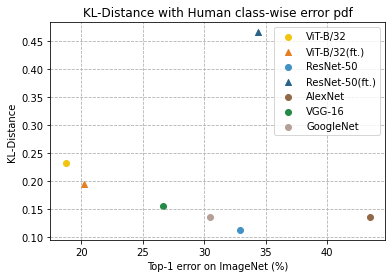

In [37]:
colors_models = {'ViT-B/32': '#F1C40F', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50(ft.)': '#296389', 'ResNet-50': '#4292C6', 'AlexNet': '#916946', 'GoogleNet': '#B4A096', 'VGG-16': '#238b45'}
colors_scatter_ft = {'ViT-B/32': '#E67E22', 'ViT-B/32(ft.)': '#E67E22', 'ResNet-50': '#296389', 'ResNet-50(ft.)': '#296389'}

for model in kl_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_class[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_class[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human class-wise error pdf')
plt.legend()
plt.show()

### Plot KL distance for inter-class errors

Model: ViT-B/32, 	 KL-Distance: 0.961
Model: ViT-B/32(ft.), 	 KL-Distance: 0.825
Model: ResNet-50, 	 KL-Distance: 1.327
Model: ResNet-50(ft.), 	 KL-Distance: 0.725
Model: AlexNet, 	 KL-Distance: 1.010
Model: VGG-16, 	 KL-Distance: 1.090
Model: GoogleNet, 	 KL-Distance: 1.184


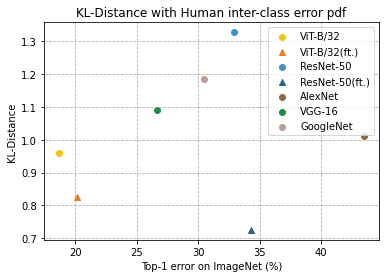

In [38]:
for model in kl_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.scatter((1-acc_im[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, kl_dist_inter[model], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t KL-Distance: {kl_dist_inter[model]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)')
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)')
plt.ylabel('KL-Distance')
plt.title('KL-Distance with Human inter-class error pdf')
plt.legend()
plt.show()

### Plot JS distance for class-wise errors

Model: ViT-B/32, 	 JS-Distance: 0.298
Model: ViT-B/32(ft.), 	 JS-Distance: 0.287
Model: ResNet-50, 	 JS-Distance: 0.256
Model: ResNet-50(ft.), 	 JS-Distance: 0.398
Model: AlexNet, 	 JS-Distance: 0.269
Model: VGG-16, 	 JS-Distance: 0.282
Model: GoogleNet, 	 JS-Distance: 0.279


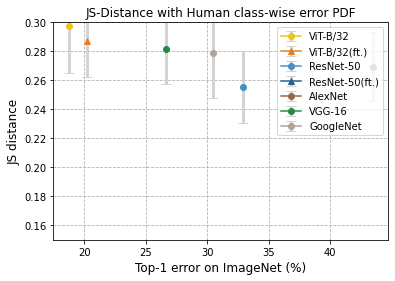

In [39]:
js_dist_class_exp[experiment] = js_dist_class

for model in js_dist_class.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_class[model][0], js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_class[model][0], label = model[:-3]+'(ft.)' if model.endswith('(ft.)') else model, marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.ylim([0.15, 0.3])
plt.legend(loc='upper right')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_class-wise_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human class-wise error PDF')
plt.show()

### Plot JS distance for inter-class errors

Model: ViT-B/32, 	 JS-Distance: 0.730
Model: ViT-B/32(ft.), 	 JS-Distance: 0.720
Model: ResNet-50, 	 JS-Distance: 0.700
Model: ResNet-50(ft.), 	 JS-Distance: 0.739
Model: AlexNet, 	 JS-Distance: 0.694
Model: VGG-16, 	 JS-Distance: 0.687
Model: GoogleNet, 	 JS-Distance: 0.689


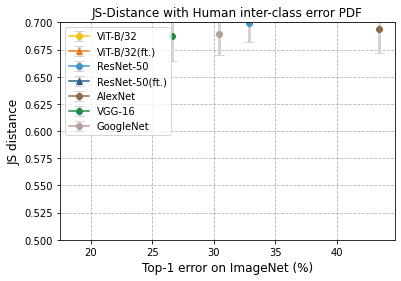

In [40]:
js_dist_inter_exp[experiment] = js_dist_inter

for model in js_dist_inter.keys():
  if PLOT_IMAGENET_ACC:
    plt.errorbar((1-acc_im[model])*100, js_dist_inter[model][0], js_dist_inter[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
    # plt.scatter((1-acc_im[model])*100, js_dist_inter[model], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  else:
    plt.scatter((1-acc_exp[model])*100, js_dist_inter[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_inter[model][0]:0.3f}')

plt.grid(linestyle='--')
if PLOT_IMAGENET_ACC:
  plt.xlabel(f'Top-1 error on ImageNet (%)', fontsize=12)
else:
  plt.xlabel(f'Top-1 error on {experiment} (%)', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.ylim([0.5, 0.7])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_inter-class_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Human inter-class error PDF')
plt.show()

### Plot JS distance between misclassifications per class

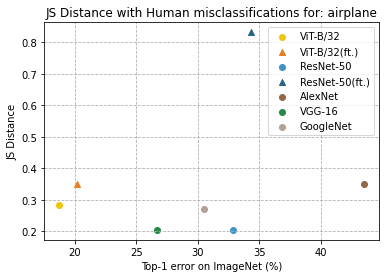

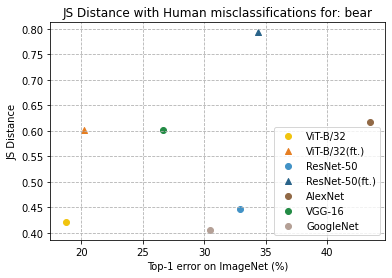

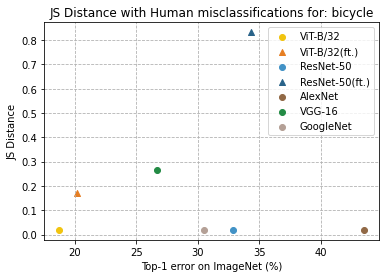

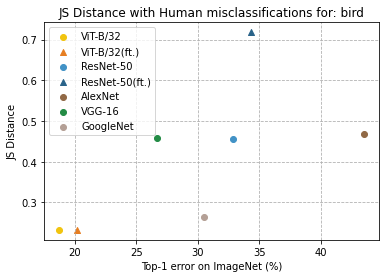

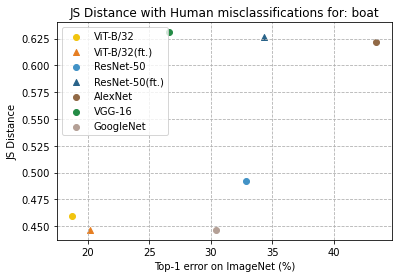

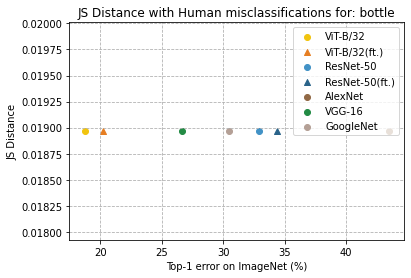

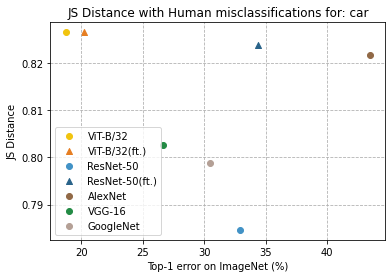

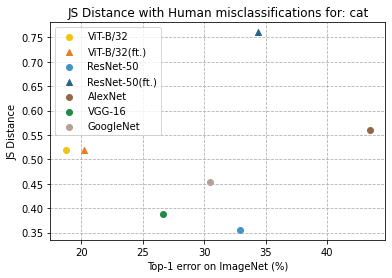

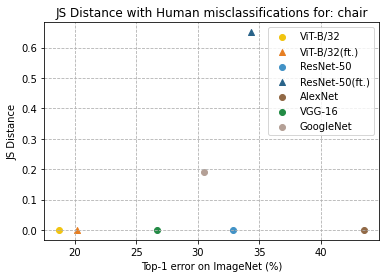

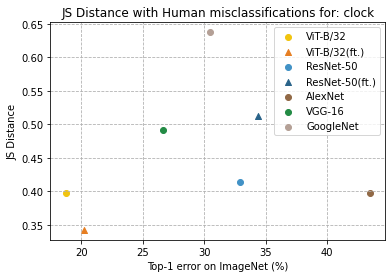

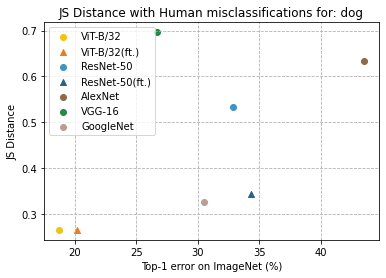

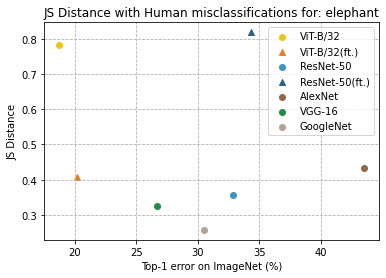

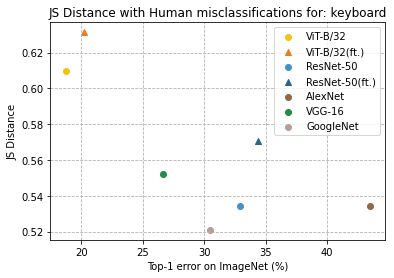

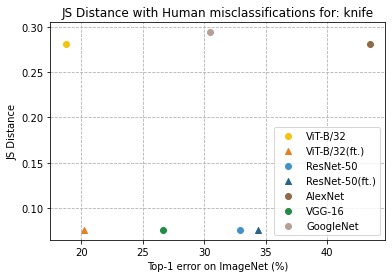

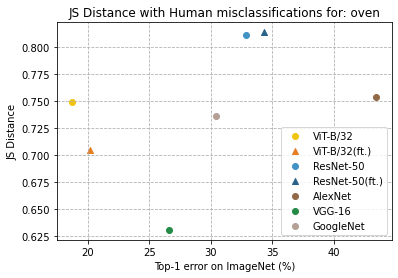

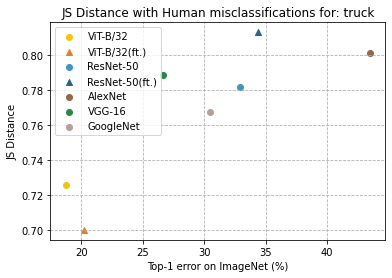

In [41]:
for category in categories_SIN:
  for model in js_misclassification.keys():
    if PLOT_IMAGENET_ACC:
      plt.scatter((1-acc_im[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')  
    else:
      plt.scatter((1-acc_exp[model])*100, js_misclassification[model][category][0], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  
  plt.grid(linestyle='--')
  if PLOT_IMAGENET_ACC:
    plt.xlabel(f'Top-1 error on ImageNet (%)')
  else:
    plt.xlabel(f'Top-1 error on {experiment} (%)')
  plt.ylabel('JS Distance')
  plt.title(f'JS Distance with Human misclassifications for: {category}')
  plt.legend()
  plt.show()

### Plot all JS distances in one graph

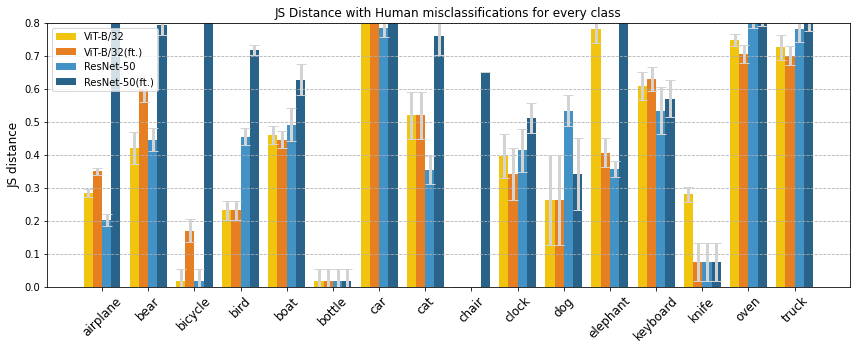

In [42]:
x = np.arange(len(categories_SIN))
width = 0.2

fig, ax = plt.subplots(figsize=[12, 4.8])

count = 0
for model in js_misclassification.keys():
  if not (model.startswith('ViT') or model.startswith('ResNet')): continue
  ax.bar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], width, label=model, color=colors_models[model])
  ax.errorbar(x - 3*width/2 + width*count, [js_misclassification[model][cat][0] for cat in categories_SIN], fmt='none', yerr=[js_misclassification[model][cat][1] for cat in categories_SIN], capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
plt.xticks(rotation=45)
ax.set_xticklabels(categories_SIN, fontsize=12)
ax.legend()
ax.set_ylim([0, 0.8])
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_misclassifications_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('JS Distance with Human misclassifications for every class')
plt.show()

### Plot correlation with Cohen's Kappa

Model: ViT-B/32, 	 JS-Distance: 0.298, 	 Cohen's Kappa: 0.367
Model: ViT-B/32(ft.), 	 JS-Distance: 0.287, 	 Cohen's Kappa: 0.378
Model: ResNet-50, 	 JS-Distance: 0.256, 	 Cohen's Kappa: 0.428
Model: ResNet-50(ft.), 	 JS-Distance: 0.398, 	 Cohen's Kappa: 0.111
Model: AlexNet, 	 JS-Distance: 0.269, 	 Cohen's Kappa: 0.334
Model: VGG-16, 	 JS-Distance: 0.282, 	 Cohen's Kappa: 0.321
Model: GoogleNet, 	 JS-Distance: 0.279, 	 Cohen's Kappa: 0.390


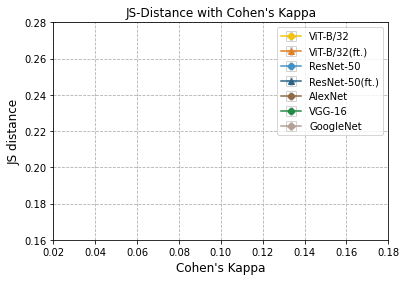

In [43]:
cohens_k = {}

cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{experiment}/texture-shape_{experiment}_kappa.csv')

for model in js_dist_class.keys():
  cohens_k[model] = mean_confidence_interval(cohens_csv[model])

for model in js_dist_class.keys():
  plt.errorbar(cohens_k[model][0], js_dist_class[model][0], xerr=cohens_k[model][1], yerr=js_dist_class[model][1], capsize=5, ecolor='lightgray', elinewidth=3, label=model, color=colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o')
  # plt.scatter(cohens_k[model][0], js_dist_class[model][0], label = model, color = colors_scatter[model], marker = '^' if model.endswith('(ft.)') else 'o')
  print(f'Model: {model}, \t JS-Distance: {js_dist_class[model][0]:0.3f}, \t Cohen\'s Kappa: {cohens_k[model][0]:0.3f}')

plt.grid(linestyle='--')
plt.xlabel('Cohen\'s Kappa', fontsize=12)
plt.ylabel('JS distance', fontsize=12)
plt.legend()
plt.xlim([0.02, 0.18])
plt.ylim([0.16, 0.28])
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_{experiment}.pdf', bbox_inches = 'tight')
plt.title('JS-Distance with Cohen\'s Kappa')
plt.show()

### Plot all metrics (all models)



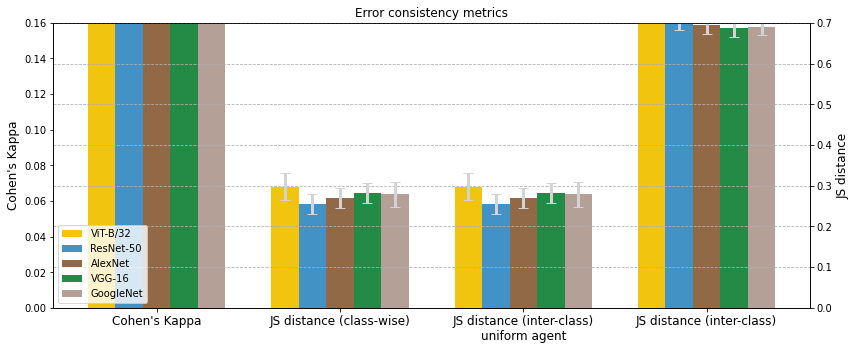

In [44]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if model.endswith('(ft.)'): continue
  ax.bar(x[0] - 4*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 4*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 4*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.16])
ax2.set_ylim([0, 0.7])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

### Plot all metrics (fine-tuning)



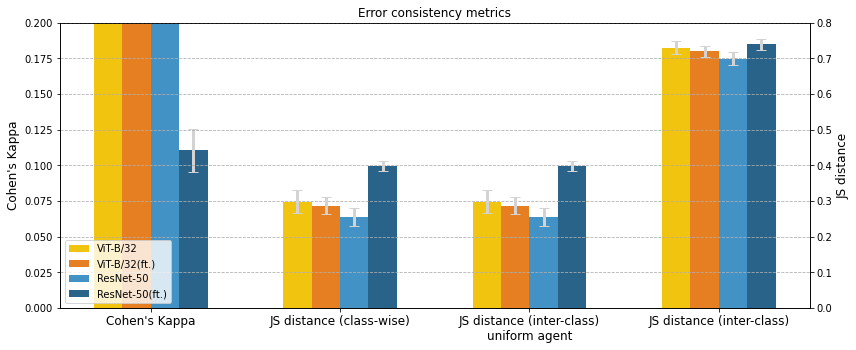

In [45]:
metrics = ['Cohen\'s Kappa', 'JS distance (class-wise)', 'JS distance (inter-class)\nuniform agent', 'JS distance (inter-class)']
x = np.arange(len(metrics))
width = 0.15

fig, ax = plt.subplots(figsize=[12, 4.8])
ax2 = ax.twinx()

count = 0
for model in all_models.values():
  if (model.startswith('VGG') or model.startswith('Alex') or model.startswith('Google')): continue
  ax.bar(x[0] - 3*width/2 + width*count, cohens_k[model][0], width, label=model, color=colors_models[model])
  ax.errorbar(x[0] - 3*width/2 + width*count, cohens_k[model][0], yerr=cohens_k[model][1], capsize=5, ecolor='lightgray', elinewidth=3)
  ax2.bar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], width, label=model, color=colors_models[model])
  ax2.errorbar(x[1:] - 3*width/2 + width*count, [js_dist_class[model][0], js_dist_inter_uniform[model][0], js_dist_inter[model][0]], yerr=[js_dist_class[model][1], js_dist_inter_uniform[model][1], js_dist_inter[model][1]], fmt='none', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax.set_ylabel('Cohen\'s Kappa', fontsize=12)
ax2.set_ylabel('JS distance', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 0.2])
# ax.set_yticks(np.linspace(ax.get_yticks()[0], ax.get_yticks()[-1], len(ax2.get_yticks())))
ax2.set_ylim([0, 0.8])
ax2.legend(loc='lower left')
fig.tight_layout()
plt.grid(axis = 'y', linestyle='--')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/error_consistency_{experiment}_ft.pdf', bbox_inches = 'tight')
ax.set_title('Error consistency metrics')
plt.show()

## Additional Figures

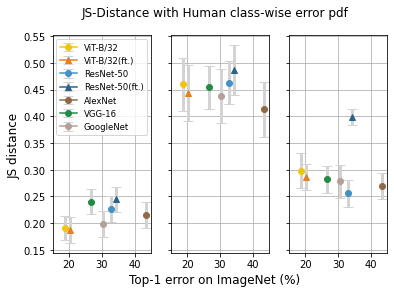

In [46]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)

experiments = ['cue-conflict', 'edges', 'silhouettes']

count = 0
for exp in experiments:
  for model in js_dist_class_exp[exp].keys():
    ax[count].errorbar((1-acc_im[model])*100, js_dist_class_exp[exp][model][0], yerr=js_dist_class_exp[exp][model][1], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(prop={'size': 8.5})
plt.xlim([15, 45])
fig.text(0.5, 0.02, 'Top-1 error on ImageNet (%)', fontsize=12, ha='center')
fig.text(0.02, 0.5, 'JS distance', fontsize=12, va='center', rotation='vertical')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_class-wise_all.pdf', bbox_inches = 'tight')
plt.suptitle('JS-Distance with Human class-wise error pdf')
plt.show()


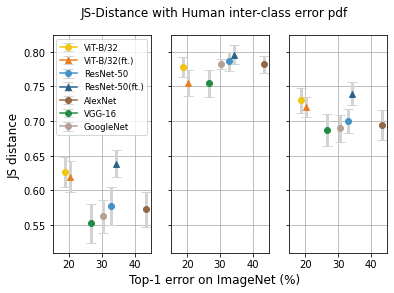

In [47]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)

experiments = ['cue-conflict', 'edges', 'silhouettes']

count = 0
for exp in experiments:
  for model in js_dist_inter_exp[exp].keys():
    ax[count].errorbar((1-acc_im[model])*100, js_dist_inter_exp[exp][model][0], yerr=js_dist_inter_exp[exp][model][1], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(prop={'size': 8.5})
plt.xlim([15, 45])
fig.text(0.5, 0.02, 'Top-1 error on ImageNet (%)', fontsize=12, ha='center')
fig.text(0.02, 0.5, 'JS distance', fontsize=12, va='center', rotation='vertical')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_human_inter-class_all.pdf', bbox_inches = 'tight')
plt.suptitle('JS-Distance with Human inter-class error pdf')
plt.show()

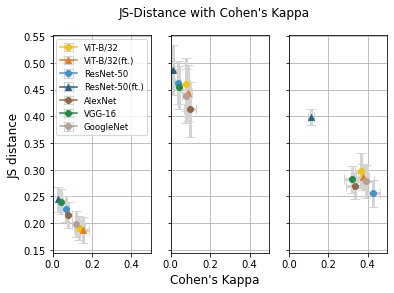

In [48]:
fig, ax = plt.subplots(1, 3, sharex = True, sharey = True)

experiments = ['cue-conflict', 'edges', 'silhouettes']

count = 0
for exp in experiments:
  cohens_k = {}
  cohens_csv = pd.read_csv(f'../figures_new_ft/texture-shape_{exp}/texture-shape_{exp}_kappa.csv')
  for model in js_dist_class.keys():
    cohens_k[model] = mean_confidence_interval(cohens_csv[model])

  for model in js_dist_class_exp[exp].keys():
    ax[count].errorbar(cohens_k[model][0], js_dist_class_exp[exp][model][0], xerr=cohens_k[model][1], yerr=js_dist_class_exp[exp][model][1], label = model, color = colors_models[model], marker = '^' if model.endswith('(ft.)') else 'o', capsize=5, ecolor='lightgray', elinewidth=3)
  count += 1

ax[0].grid()
ax[1].grid()
ax[2].grid()
ax[0].legend(prop={'size': 8.5})
plt.xlim([0, 0.5])
fig.text(0.5, 0.02, 'Cohen\'s Kappa', fontsize=12, ha='center')
fig.text(0.02, 0.5, 'JS distance', fontsize=12, va='center', rotation='vertical')
if SAVE_FIGS: plt.savefig(f'../../tests/figures/js_vs_cohen_all.pdf', bbox_inches = 'tight')
plt.suptitle('JS-Distance with Cohen\'s Kappa')
plt.show()